In [1]:
# common imports
import sys
import sklearn
import numpy as np
import os
import pandas as pd
from pathlib import Path

#figures
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
# Sets defaults/can also be imported from a style file
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

In [2]:
# Saving path to a directory
path = Path('../input/california-housing-prices')
for file in path.iterdir():
    print(file)

../input/california-housing-prices/housing.csv


In [3]:
df = pd.read_csv(path/'housing.csv', low_memory=False)
print(df.shape)

(20640, 10)


In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# Ocean_proximity is the only categorical attribute
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

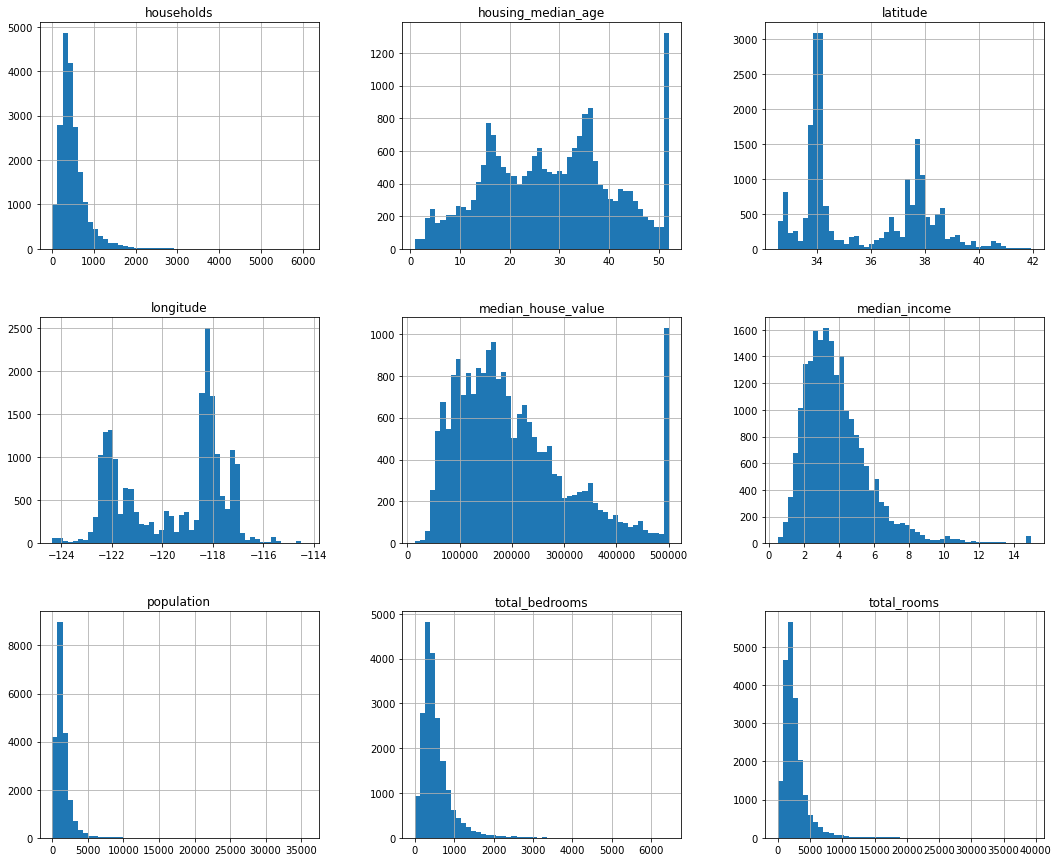

In [7]:
df.hist(bins=50, figsize=(18, 15))
plt.show()

In [8]:
import hashlib
hash = hashlib.md5

In [9]:
# In built hash function
ans = hash(np.int64(1000))
print(ans)
print(ans.digest())
print(ans.digest_size) 
# gives the size of the last bit in the digest
print((ans.digest()[-1])); print(ans.digest()[15])

<md5 HASH object @ 0x7f524c01cbd0>
b'jht\x88D\x00\xea\xcf\x8eo\x8c\x87Pyq\xfd'
16
253
253


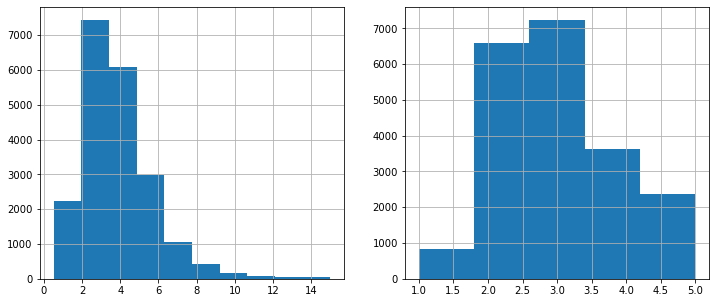

In [10]:
fig, axs = plt.subplots(1,2)
df["median_income"].hist(ax=axs[0], figsize= (12, 5))
# Reduce bins to get better understanding
df['income_cat'] = pd.cut(df['median_income'], bins = [0, 1.5, 3.0, 4.5, 6., np.inf],
                         labels=[1, 2, 3, 4, 5])
df['income_cat'].hist(bins = 5, ax=axs[1], figsize=(12, 5))
plt.show()

## Train-Test split based on original dataset(a column) proportions

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# looping over in this case doesn't matter as splits = 1
# multiple splits are used for CV
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [12]:
print(df['income_cat'].value_counts()/len(df))
print(strat_test_set['income_cat'].value_counts()/len(strat_test_set))
# Very similar proportions

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64
3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


In [13]:
# Doing Random split vs Stratified Split
from sklearn.model_selection import train_test_split
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
print(compare_props)

    Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039729  0.040213      0.973236      -0.243309
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114583  0.109496     -4.318374       0.127011


In [14]:
# Removed because the origina repo removes it
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [15]:
df_new = strat_train_set.copy() # .copy() should be used as otherwise it keeps referring to the same menory location

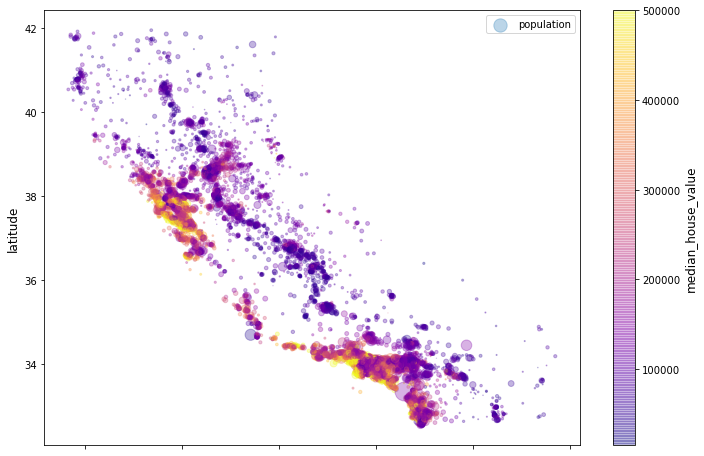

In [16]:
df_new.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3, s=df_new['population']/100,
           label='population', figsize=(12, 8), c='median_house_value', cmap=plt.get_cmap("plasma"), 
           colorbar=True)
plt.legend()
plt.show()

In [17]:
import urllib
# Download the California image
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, filename)

('california.png', <http.client.HTTPMessage at 0x7f5247ae9190>)

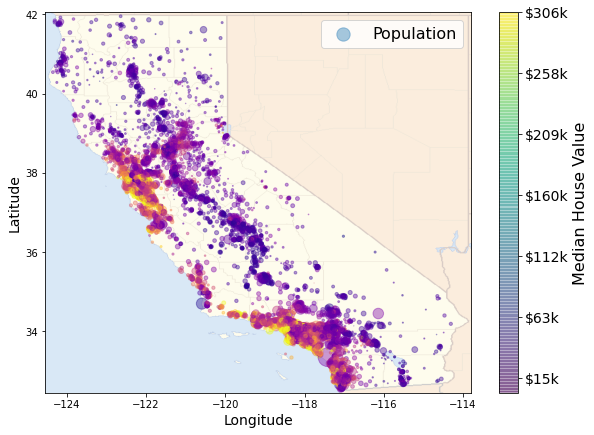

In [18]:
import matplotlib.image as mpimg
land = mpimg.imread(filename)
# Colorbar is False as we set it later
ax = df_new.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=df_new['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("plasma"),
                       colorbar=False, alpha=0.4)
plt.imshow(land, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.4)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df_new["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

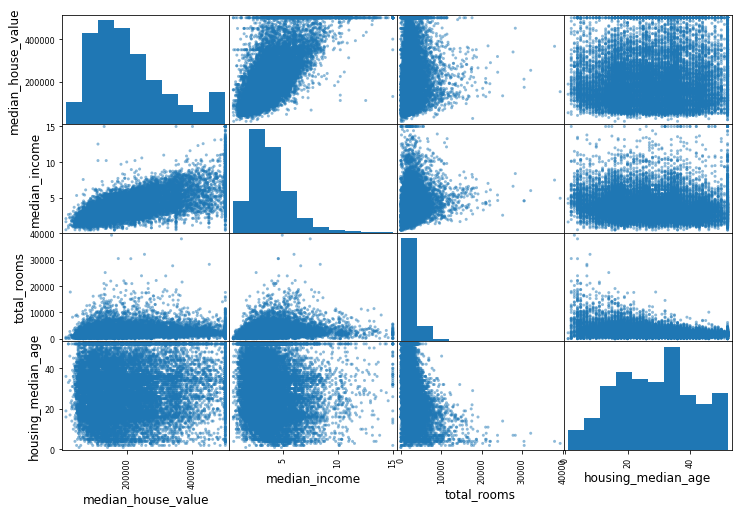

In [19]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
# for same x and y we plotted it as histogram since scatter plot won't give any vital info
scatter_matrix(df_new[attributes], figsize=(12, 8))
plt.show()
# Here other than median income and median house value others don't show much correlation

In [20]:
corr = df_new.corr()
corr['median_house_value'].sort_values(ascending=False)
# Verifies above graph 

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

### Cleaning dataset 

In [21]:
x_unclean = strat_train_set.drop('median_house_value', axis=1)
y_unclean = strat_train_set["median_house_value"]

In [22]:
incomplete_rows = x_unclean[x_unclean.isnull().any(axis=1)]
# default method(axis=0)ends up using only bool values for each column so can't be hashed
incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [23]:
# Methods discussed in book
# Ends up dropping all rows with nan vals
incomplete_rows.dropna(subset=['total_bedrooms'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [24]:
# drops column with nan values from dataframe
incomplete_rows.drop('total_bedrooms', axis=1).head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [25]:
# Filling nan values with median
median_val = x_unclean['total_bedrooms'].median()
incomplete_rows['total_bedrooms'].fillna(median_val).head()

4629     433.0
6068     433.0
17923    433.0
13656    433.0
19252    433.0
Name: total_bedrooms, dtype: float64

In [26]:
# Another way to achieve above is use sklearn Imputer class
from sklearn.impute import SimpleImputer
impute = SimpleImputer(strategy='median')

In [27]:
# Remove text features as imputer won't work for them
x_nums = x_unclean.drop('ocean_proximity', axis=1)

In [28]:
impute.fit(x_nums)
impute.statistics_
# These are the median values of all the columns

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [29]:
x_nums_arr = impute.transform(x_nums)
# This gives numpy array so we need to convert to dataFrame for convenient viewing
df_nums = pd.DataFrame(x_nums_arr, columns=x_nums.columns, index=x_nums.index)

In [30]:
df_nums.loc[incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662
...,...,...,...,...,...,...,...,...
3376,-118.28,34.25,29.0,2559.0,433.0,1886.0,769.0,2.6036
4691,-118.37,34.07,50.0,2519.0,433.0,1117.0,516.0,4.3667
6052,-117.76,34.04,34.0,1914.0,433.0,1564.0,328.0,2.8347
17198,-119.75,34.45,6.0,2864.0,433.0,1404.0,603.0,5.5073


In [31]:
# Now for categorical data
from sklearn.preprocessing import OrdinalEncoder
ordinal = OrdinalEncoder()
x_cat = ordinal.fit_transform(x_unclean[['ocean_proximity']])

In [32]:
x_cat[:-10], ordinal.categories_

(array([[0.],
        [0.],
        [4.],
        ...,
        [0.],
        [0.],
        [0.]]),
 [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)])

In [33]:
# for non hierarchical categories
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [34]:
x_cat_one = encoder.fit_transform(x_unclean[['ocean_proximity']])
x_cat_one

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [35]:
# Sparse array reprsentation saves memory
# Converting to dense array / set sparse=False for OneHotEncoder to directly get dense representation
x_cat_one.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

*  https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65(Ref)


Scikit-Learn provides us with two great base classes, TransformerMixin and BaseEstimator. Inheriting from TransformerMixin 
ensures that all we need to do is write our fit and transform methods and we get fit_transform for free. 
Inheriting from BaseEstimator ensures we get get_params and set_params for free. Since the fit method doesn’t need to 
do anything but return the object itself, all we really need to do after inheriting from these classes, 
is define the transform method for our custom transformer and we get a fully functional custom transformer that 
can be seamlessly integrated with a scikit-learn pipeline

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedroom_per_room = True): 
        self.add_bedroom_per_room = add_bedroom_per_room
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix]/X[:, households_ix]
        population_per_household = X[:, population_ix]/X[:, households_ix]
        if self.add_bedroom_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [37]:
attr_adder = CombinedAttributesAdder(add_bedroom_per_room=True)
attr_adder.get_params()

{'add_bedroom_per_room': True}

In [38]:
x_unclean_fe = attr_adder.transform(x_unclean.values)
# This is a numpy array, so we convert to pandas to view properly

In [39]:
x_unclean_fe = pd.DataFrame(x_unclean_fe, 
                            columns=list(x_unclean.columns) + ['rooms_per_household', 'population_per_household', 'bedrooms_per_room'])
x_unclean_fe.head()                                                               

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944,0.223852
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796,0.159057
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597,0.241291
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598,0.200866
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785,0.231341


### Building a pipeline for data transformation

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Pipeline for Transforming all numerical categories
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

# The pipeline Constructor separate pipelines for numerical and categorical attributes
# We can group them together using Column Transformer

from sklearn.compose import ColumnTransformer

num_attr = list(x_nums.columns)
cat_attr = ['ocean_proximity']

comb_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attr), 
    ("cat", OneHotEncoder(), cat_attr)
])


In [41]:
x_clean = comb_pipeline.fit_transform(x_unclean)
# above pipeline converts to array

In [42]:
x_unclean.shape

(16512, 9)

### Training Models with Cross-Validation

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [44]:
def scores(score):
    print("Scores", score)
    print("Mean", score.mean())
    print("Standard Deviation", score.std())

In [45]:
rf = RandomForestRegressor()
rf_scores = cross_val_score(rf, x_clean, y_unclean,
                           scoring='neg_mean_squared_error', cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
scores(rf_scores)
scores(rf_rmse_scores)

Scores [-2.41957237e+09 -2.27944106e+09 -2.48635734e+09 -2.72377227e+09
 -2.50185656e+09 -2.86681661e+09 -2.39314101e+09 -2.29235816e+09
 -2.81700902e+09 -2.50364672e+09]
Mean -2528397111.0925493
Standard Deviation 196700511.39716807
Scores [49189.14890307 47743.49232309 49863.38672062 52189.77165616
 50018.56214738 53542.66163316 48919.74051226 47878.5772391
 53075.50302921 50036.4538617 ]
Mean 50245.72980257556
Standard Deviation 1940.0380664096897


## Exercise

## Q1

In [46]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [47]:
params = [
    {
        'kernel':['linear'], 'C':[0.1, 0.5, 1, 10, 50, 100]
    },
    {
        'kernel':['rbf'], 'C':[0.1, 0.5, 1, 10, 50, 100], 'gamma':[0.01, 0.03, 0.1, 0.3, 1.0]
    }
]

In [48]:
svm = SVR(cache_size=500)
grid_search = GridSearchCV(svm, params, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(x_clean, y_unclean)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=0.1, kernel=linear, total=  10.3s
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s


[CV] ............................. C=0.1, kernel=linear, total=  10.4s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  10.5s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  10.4s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  10.4s
[CV] C=0.5, kernel=linear ............................................
[CV] ............................. C=0.5, kernel=linear, total=  10.5s
[CV] C=0.5, kernel=linear ............................................
[CV] ............................. C=0.5, kernel=linear, total=  10.4s
[CV] C=0.5, kernel=linear ............................................
[CV] ............................. C=0.5, kernel=linear, total=  10.2s
[CV] C=0.5, kernel=linear ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 45.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=500, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 0.5, 1, 10, 50, 100],
                          'kernel': ['linear']},
                         {'C': [0.1, 0.5, 1, 10, 50, 100],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [49]:
neg_mse = grid_search.best_score_
rmse = np.sqrt(-neg_mse)
rmse

71603.17710755806

## Q2

In [50]:
from sklearn.model_selection import RandomizedSearchCV

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
params_rand = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

rnd_search = RandomizedSearchCV(svm, params_rand,
                                n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(x_clean, y_unclean)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.2s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.2s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.1s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.1s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.3s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.9s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.6s
[CV] C=26290.2

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 33.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=500, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=20, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f524c46e1d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f524c1cf0d0>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [52]:
neg_mse = grid_search.best_score_
rmse = np.sqrt(-neg_mse)
rmse

71603.17710755806

In [53]:
print(grid_search.best_estimator_)

SVR(C=100, cache_size=500, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


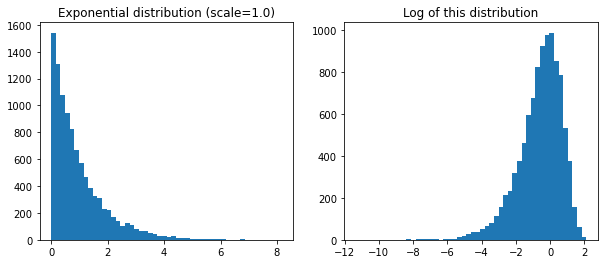

In [54]:
# Taken from exercise solution, to understand which type of distribution we should pick for our vals
# exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

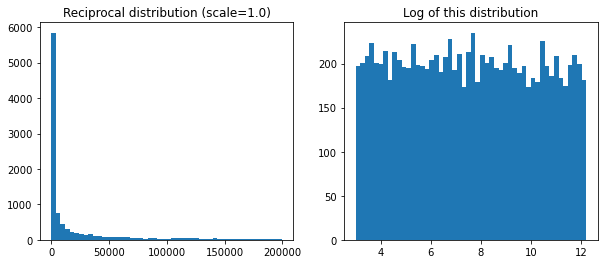

In [55]:
# The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

### Q3

In [56]:
# This assumes that the feature importances have been already calculated
from sklearn.base import BaseEstimator, TransformerMixin

class impFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importance, k):
        self.feature_importance = feature_importance
        self.k = k
    def fit(self, X, y=None):
        self.top_features = np.argsort(self.feature_importance)[-self.k:]
        return self
    def transform(self, X):
        return X[:, self.top_features]

In [57]:
rf.fit(x_clean, y_unclean)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [58]:
k=5

In [59]:
rf.feature_importances_[np.argsort(rf.feature_importances_)[-k:]]

array([0.05605944, 0.05752213, 0.12259885, 0.14043078, 0.47410632])

In [60]:
# Setting up all attribs
cat_encoder = comb_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
all_attribs = list(x_nums.columns) + ['rooms_per_household', 'population_per_household', 'bedrooms_per_room'] + cat_one_hot_attribs

In [61]:
all_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'population_per_household',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [62]:
# List of important attributes
np.array(all_attribs)[np.argsort(rf.feature_importances_)[-k:]]

array(['latitude', 'longitude', 'population_per_household', 'INLAND',
       'median_income'], dtype='<U24')

In [63]:
feature_selector_pipeline = Pipeline([
    ('preparation', comb_pipeline),
    ('feature_selection', impFeatureSelector(rf.feature_importances_, k))
])

In [64]:
top_k_attribs = feature_selector_pipeline.fit_transform(x_unclean)

In [65]:
top_k_attribs

array([[ 0.77194962, -1.15604281, -0.08649871,  0.        , -0.61493744],
       [ 0.6596948 , -1.17602483, -0.03353391,  0.        ,  1.33645936],
       [-1.34218285,  1.18684903, -0.09240499,  0.        , -0.5320456 ],
       ...,
       [-0.72478134,  1.58648943, -0.03055414,  1.        , -0.3167053 ],
       [-0.85106801,  0.78221312,  0.06150916,  0.        ,  0.09812139],
       [ 0.99645926, -1.43579109, -0.09586294,  0.        , -0.15779865]])

In [66]:
# Same for both cases
x_clean[:,np.argsort(rf.feature_importances_)[-k:]]

array([[ 0.77194962, -1.15604281, -0.08649871,  0.        , -0.61493744],
       [ 0.6596948 , -1.17602483, -0.03353391,  0.        ,  1.33645936],
       [-1.34218285,  1.18684903, -0.09240499,  0.        , -0.5320456 ],
       ...,
       [-0.72478134,  1.58648943, -0.03055414,  1.        , -0.3167053 ],
       [-0.85106801,  0.78221312,  0.06150916,  0.        ,  0.09812139],
       [ 0.99645926, -1.43579109, -0.09586294,  0.        , -0.15779865]])

### Q4

In [67]:
complete_pipeline = Pipeline([
    ('preparation', comb_pipeline),
    ('feature_selection', impFeatureSelector(rf.feature_importances_, k)),
    ('rf', RandomForestRegressor())
])

In [68]:
complete_pipeline.fit(x_unclean, y_unclean)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('impute',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                               

In [69]:
# Not best parameters as shown here
complete_pipeline.predict(x_unclean[100:102]), y_unclean[100:102]

(array([203034.05, 361911.01]),
 15706    117500.0
 5505     366900.0
 Name: median_house_value, dtype: float64)

### Q5 - From Solutions

In [70]:
from sklearn.model_selection import GridSearchCV

params = [{
    'preparation__num__impute__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(rf.feature_importances_) + 1))
}]

grid_search_prep = GridSearchCV(complete_pipeline, params, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(x_unclean, y_unclean)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__impute__strategy=mean .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__impute__strategy=mean, total=   2.3s
[CV] feature_selection__k=1, preparation__num__impute__strategy=mean .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__impute__strategy=mean, total=   2.2s
[CV] feature_selection__k=1, preparation__num__impute__strategy=mean .
[CV]  feature_selection__k=1, preparation__num__impute__strategy=mean, total=   2.2s
[CV] feature_selection__k=1, preparation__num__impute__strategy=mean .
[CV]  feature_selection__k=1, preparation__num__impute__strategy=mean, total=   2.2s
[CV] feature_selection__k=1, preparation__num__impute__strategy=mean .
[CV]  feature_selection__k=1, preparation__num__impute__strategy=mean, total=   2.2s
[CV] feature_selection__k=1, preparation__num__impute__strategy=median 
[CV]  feature_selection__k=1, preparation__num__impute__strategy=median, total=   2.2s
[CV] feature_selection__k=1, preparation__num__impute__strategy=median 
[CV]  feature_selection__k=1, preparation__num__impute__strategy=median, total=   2.2s
[CV] feature_selection__k=1, preparation__num__impute__strategy=median 
[CV]  feature_selection__k=1, preparation__num__impute__s

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 35.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('impute',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                      

In [71]:
grid_search_prep.best_params_

{'feature_selection__k': 8, 'preparation__num__impute__strategy': 'mean'}